### Load the dataset. Create an Analyzer object.

In [1]:
from sklearn import datasets
import pandas as pd
pd.set_option('display.max_columns', None)
import sys
sys.path.append('../../')
import tabularmagic as tm

diabetes = datasets.load_diabetes()
data = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
target = pd.Series(diabetes.target, name='target')
df = pd.concat([data, target], axis=1)

analyzer = tm.Analyzer(df, test_size=0.2, name='Diabetes scikit-learn dataset')
analyzer

INFO: Analyzer initialized. Shapes of train, test DataFrames: (353, 11), (89, 11). 


Diabetes scikit-learn dataset 
----------------------------------------------------------------------------------------
Train shape: (353, 11)                       Test shape: (89, 11)                       
----------------------------------------------------------------------------------------
Categorical variables:
  None 
                                                                                        
Numerical variables:
  'age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'target' 

### Conduct exploratory analysis

Visualize the distribution of the target variable statified by sex

INFO: Working DataFrames reset to original DataFrames. Shapes of train, test DataFrames: 
      (353, 11), (89, 11). 


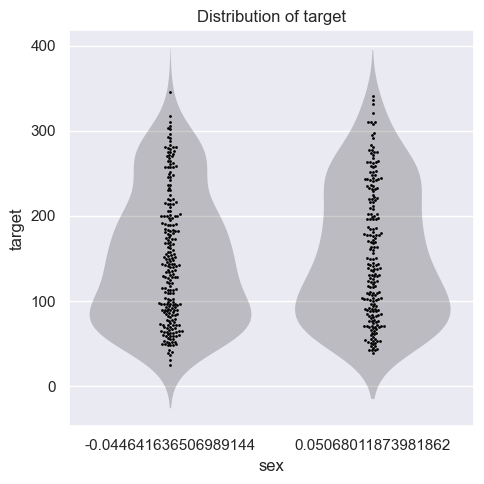

In [2]:
analyzer.datahandler().load_data_checkpoint() # load default data checkpoint
analyzer.eda(dataset='all').plot_distribution_stratified(
    'target', 'sex', strategy='violin_swarm'
)

Visualize the distribution of the target variable in relation with bmi, age, bp

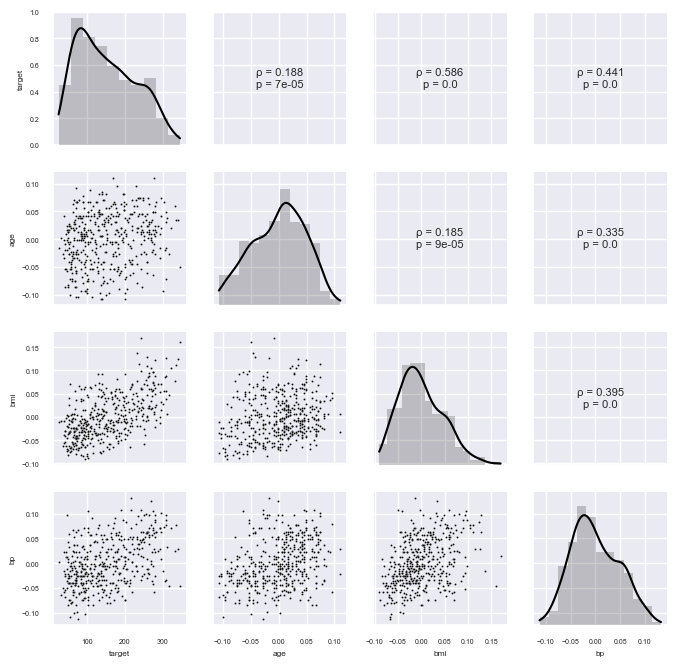

In [3]:
analyzer.eda(dataset='all').plot_numerical_pairs(
    ['target', 'age', 'bmi', 'bp']
)

### Regression analysis

Fit a multivariate linear model

In [4]:
lm_report = analyzer.lm(
    formula='target ~ age + bmi + bp + sex + bp:sex'
)
lm_report.statsmodels_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     78.41
Date:                Sun, 14 Jul 2024   Prob (F-statistic):           7.28e-55
Time:                        01:55:02   Log-Likelihood:                -1940.0
No. Observations:                 353   AIC:                             3892.
Df Residuals:                     347   BIC:                             3915.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        150.4756      3.199     47.045      0.000     144.207     156.745
age           66.5596     68.288      0.975      0.330     -67.281     200.401
bmi          817.1307     75.365     10.842      0.000     669.417     964.844
bp           418.6492     75.770      5.525      0.000     270.143     567.155
sex         -110.2164     66.221     -1.664      0.096    -240.008      19.575
bp:sex      3082.4923   1304.186      2.364      0.018     526.334    5638.650
==============================================================================
Omnibus:                        9.655   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                5.330
Skew:                           0.072   Prob(JB):                       0.0696
Kurtosis:                       2.415   Cond. No.                         451.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

View the diagnostic plots

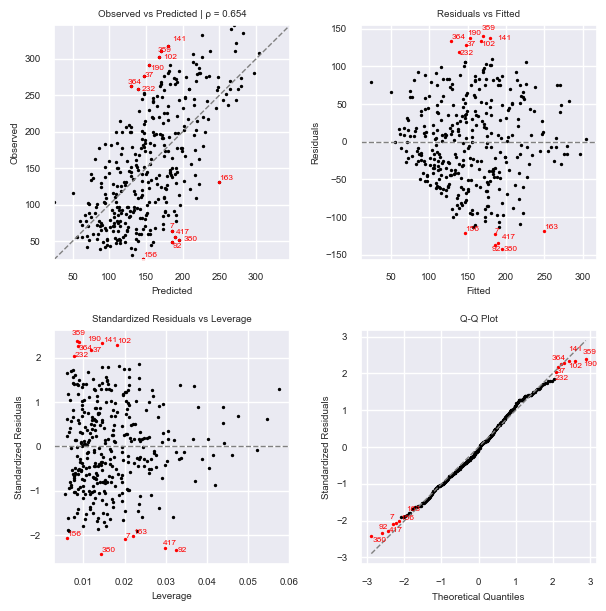

In [5]:
lm_report.train_report().set_outlier_threshold(2).plot_diagnostics(
    show_outliers=True)

View model metrics

In [6]:
display(lm_report.metrics('train'))

# alternatively...
display(lm_report.train_report().metrics())

,OrdinaryLeastSquares
Statistic,
rmse,58.954531
mad,48.701527
pearsonr,0.654225
spearmanr,0.623311
r2,0.42801
adjr2,0.419768
n,353


,OrdinaryLeastSquares
Statistic,
rmse,58.954531
mad,48.701527
pearsonr,0.654225
spearmanr,0.623311
r2,0.42801
adjr2,0.419768
n,353


In [7]:
display(lm_report.metrics('test'))

# alternatively...
display(lm_report.test_report().metrics())

,OrdinaryLeastSquares
Statistic,
rmse,60.750438
mad,49.979177
pearsonr,0.561894
spearmanr,0.552851
r2,0.303415
adjr2,0.261452
n,89


,OrdinaryLeastSquares
Statistic,
rmse,60.750438
mad,49.979177
pearsonr,0.561894
spearmanr,0.552851
r2,0.303415
adjr2,0.261452
n,89


### Machine learning regression benchmarking

Each model performs a grid search to find optimal estimator. Nested k-fold cross validation is performed to assess model fit on train. Models are also assesed on test.

In [8]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
import numpy as np


ml_report = analyzer.ml_regression(
    models=[
        tm.ml.CustomR(
            estimator=Lasso(alpha=0.1),
            name='Lasso alpha=0.1'
        ),
        tm.ml.CustomR(
            estimator=GridSearchCV(
                estimator=Lasso(alpha=0.5),
                param_grid={'alpha': np.logspace(-4, 4, 10)},
            ),
            name='Lasso with gridsearch'
        ),
        tm.ml.CustomR(
            estimator=Pipeline(
                steps=[
                    ('feature_selection', SelectKBest(k=2)),
                    ('regression', GridSearchCV(
                        estimator=Lasso(alpha=0.5),
                        param_grid={'alpha': np.logspace(-4, 4, 10)}
                    ))
                ]
            ),
            name='pipeline example'
        ),
        tm.ml.LinearR('l1'),
        tm.ml.TreeR()
    ],
    target='target',
    predictors=['age', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'],
    outer_cv=5,
    outer_cv_seed=0
)

INFO: Evaluating model Lasso alpha=0.1. 
PROG: Fitting Lasso alpha=0.1. 
PROG: Fitting Lasso alpha=0.1. 
PROG: Fitting Lasso alpha=0.1. 
PROG: Fitting Lasso alpha=0.1. 
PROG: Fitting Lasso alpha=0.1. 
PROG: Fitting Lasso alpha=0.1. 
INFO: Successfully evaluated model Lasso alpha=0.1. 
INFO: Evaluating model Lasso with gridsearch. 
PROG: Fitting Lasso with gridsearch. 
PROG: Fitting Lasso with gridsearch. 
PROG: Fitting Lasso with gridsearch. 
PROG: Fitting Lasso with gridsearch. 
PROG: Fitting Lasso with gridsearch. 
PROG: Fitting Lasso with gridsearch. 
INFO: Successfully evaluated model Lasso with gridsearch. 
INFO: Evaluating model pipeline example. 
PROG: Fitting pipeline example. 
PROG: Fitting pipeline example. 
PROG: Fitting pipeline example. 
PROG: Fitting pipeline example. 
PROG: Fitting pipeline example. 
PROG: Fitting pipeline example. 
INFO: Successfully evaluated model pipeline example. 
INFO: Evaluating model LinearR(l1). 
PROG: Fitting LinearR(l1). Search method: OptunaS

View test fit statistics

In [9]:
ml_report.metrics('test')

,Lasso alpha=0.1,Lasso with gridsearch,pipeline example,LinearR(l1),TreeR
Statistic,,,,,
rmse,53.766228,54.034104,53.856748,53.854738,62.442698
mad,43.798108,43.870287,44.080882,43.824555,50.03595
pearsonr,0.67637,0.674763,0.673109,0.675863,0.533313
spearmanr,0.664343,0.664394,0.660129,0.664266,0.517769
r2,0.454374,0.448924,0.452536,0.452576,0.264066
adjr2,0.392215,0.386143,0.390166,0.390212,0.180225
n,89,89,89,89,89


View train fit statistics

In [10]:
ml_report.metrics('train')

,Lasso alpha=0.1,Lasso with gridsearch,pipeline example,LinearR(l1),TreeR
Statistic,,,,,
rmse,54.942068,54.771258,57.381337,54.862597,61.245981
mad,45.175939,44.94668,47.634954,45.080836,50.470623
pearsonr,0.710459,0.711805,0.67701,0.711091,0.618613
spearmanr,0.694555,0.697025,0.667051,0.696419,0.623272
r2,0.50322,0.506304,0.45813,0.504656,0.382682
adjr2,0.490185,0.49335,0.443912,0.491659,0.366484
n,353,353,353,353,353


View averaged fit statistics across folds

In [11]:
ml_report.cv_metrics()

,Lasso alpha=0.1,Lasso with gridsearch,pipeline example,LinearR(l1),TreeR
Statistic,,,,,
rmse,55.806346,55.710156,59.225259,56.318759,65.317292
mad,46.060357,45.842629,49.355747,46.165808,53.220108
pearsonr,0.704991,0.70642,0.650358,0.69894,0.570205
spearmanr,0.681986,0.681679,0.645978,0.676907,0.586291
r2,0.477922,0.479664,0.408032,0.467905,0.285193
adjr2,0.40033,0.40233,0.320008,0.388819,0.178973
n,70.6,70.6,70.6,70.6,70.6


Obtain the scikit-learn estimator

In [12]:
ml_report.model('TreeR').sklearn_estimator()

DecisionTreeRegressor(max_depth=3, max_features='log2',
                      min_samples_leaf=0.1913041836526554,
                      min_samples_split=0.4086644924539999, random_state=42)

Obtain a custom Pipeline

In [13]:
ml_report.model('pipeline example').sklearn_estimator()

Pipeline(steps=[('feature_selection', SelectKBest(k=2)),
                ('regression',
                 GridSearchCV(estimator=Lasso(alpha=0.5),
                              param_grid={'alpha': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])}))])

View LinearR(l1) fit on train data

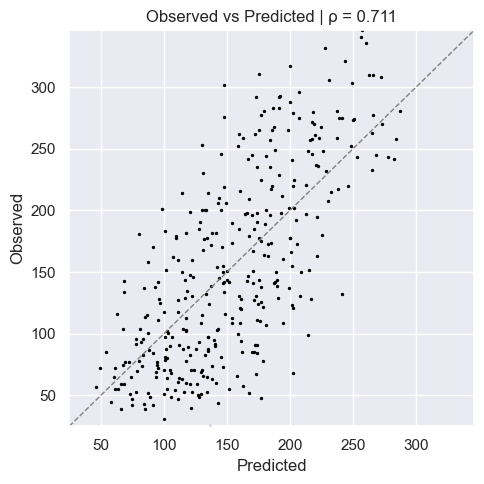

In [14]:
ml_report.model_report('LinearR(l1)').train_report().plot_obs_vs_pred()

View LinearR(l1) fit on test data

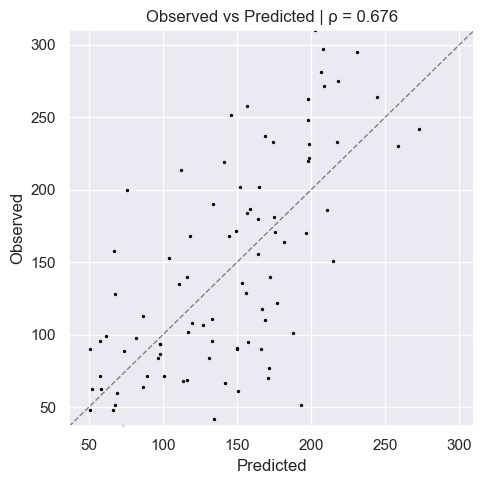

In [15]:
ml_report.model_report('LinearR(l1)').test_report().plot_obs_vs_pred()